# Bayesian AB Testing Part 2 - Simulations in Jags

In [17]:
library(ggplot2)
library(rjags)

In [7]:
# Create some fake data 
set.seed(2021)

n = 120
p_a = 0.29
p_b = 0.5

x_a = sum(rbinom(n = n, size = 1, prob = p_a))
x_b = sum(rbinom(n = n, size = 1, prob = p_b))

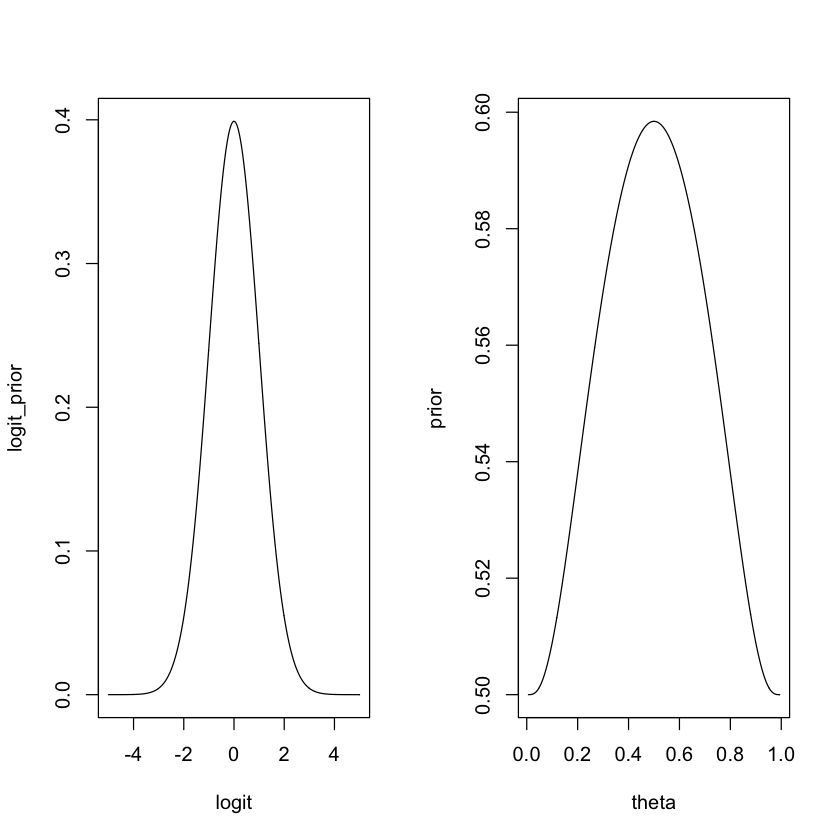

In [77]:
# A logit transformation can account for any boundary issues outside of [0,1]

logit = -500:500*0.01
logit_prior = dnorm(logit, 0, 1)

# reverse the logit to success propability 
theta = 1.0/(1.0 + exp(-logit))

par(mfrow = c(1, 2))
plot(logit, logit_prior, type = 'l')
plot(theta, prior, type = 'l')

In [93]:
model = "model {
  
  for(i in 1:2){

    # priors
    logits[i] ~ dnorm(0, 1)
  
    # Transform from logit to success prob.
    theta[i] <- 1.0/(1.0 + exp(-logits[i]))
    
    x[i] ~ dbin(theta[i], N)
  } 

    diff <- theta[2] - theta[1]

    # Probability that a variant is better or 'wins'
    # error function aka probability to be best
    ptbb[1] <- step(theta[1] - theta[2]) # will be 1 if > 0 and 0 otherwise
    ptbb[2] <- step(theta[2] - theta[1])
    
}
"

In [94]:
jm = jags.model(textConnection(model), data = list(N = n, x = c(x_a, x_b)))
out = coda.samples(jm, variable.names = c("theta", 'diff', 'ptbb[1]'), n.iter = 100000, thin=10)
results = as.data.frame(out[[1]])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 2
   Total graph size: 19

Initializing model



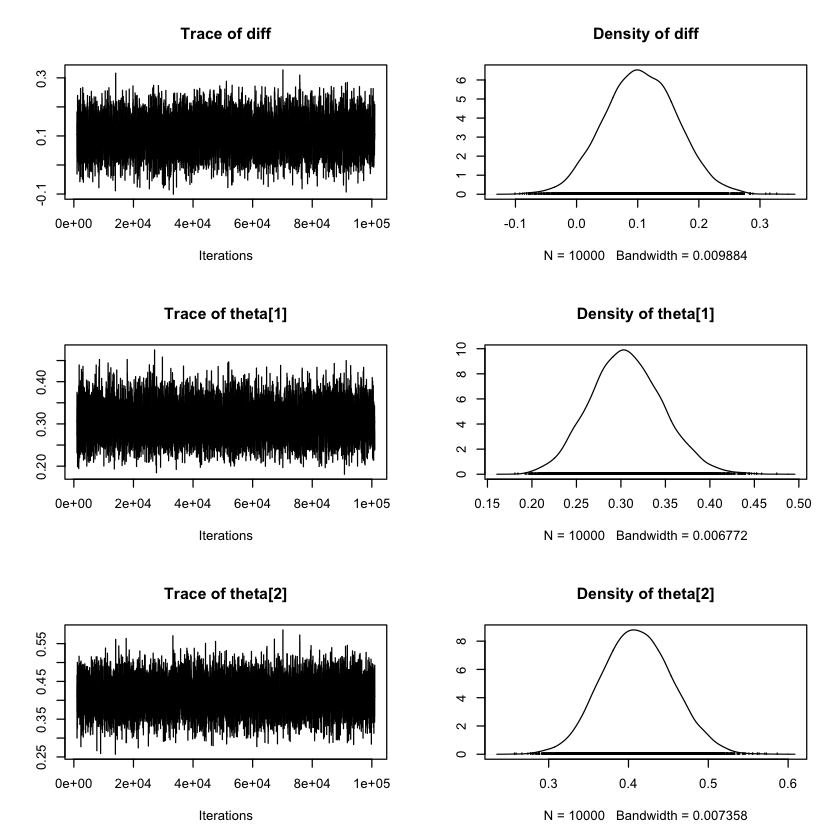

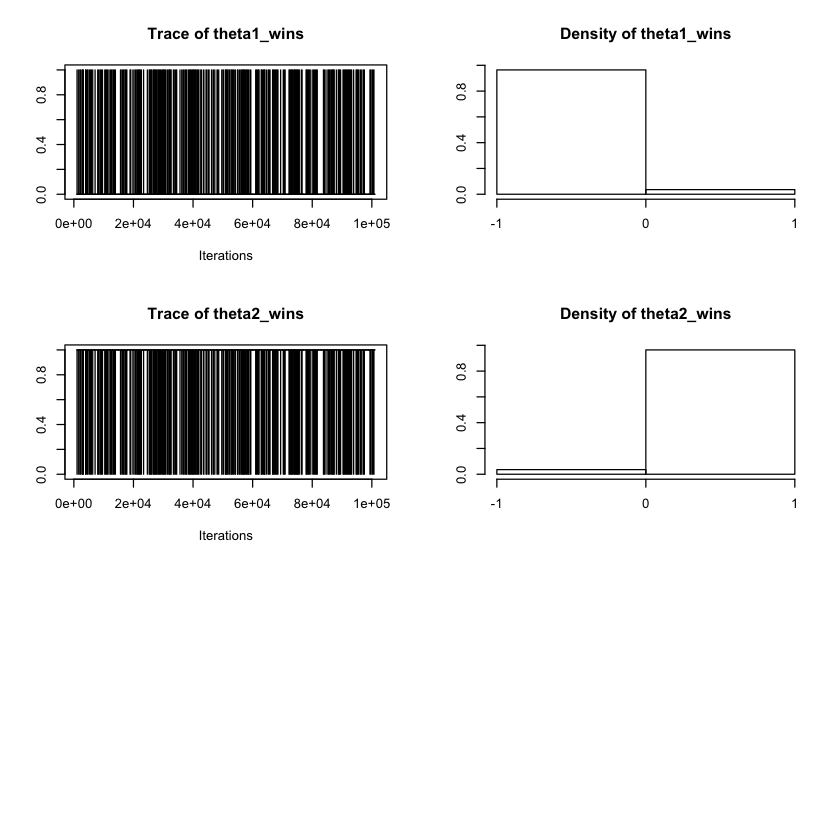

In [95]:
plot(out)

In [96]:
summary(out)


Iterations = 1010:101000
Thinning interval = 10 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean      SD  Naive SE Time-series SE
diff        0.1047 0.05884 0.0005884      0.0005884
theta[1]    0.3063 0.04042 0.0004042      0.0003940
theta[2]    0.4110 0.04380 0.0004380      0.0004380
theta1_wins 0.0358 0.18580 0.0018580      0.0018580
theta2_wins 0.9642 0.18580 0.0018580      0.0018580

2. Quantiles for each variable:

                 2.5%     25%    50%    75%  97.5%
diff        -0.009136 0.06492 0.1045 0.1453 0.2186
theta[1]     0.230186 0.27877 0.3051 0.3328 0.3882
theta[2]     0.327613 0.38080 0.4102 0.4407 0.4981
theta1_wins  0.000000 0.00000 0.0000 0.0000 1.0000
theta2_wins  0.000000 1.00000 1.0000 1.0000 1.0000


In [97]:
sum(results$`theta[1]` > results$`theta[2]`)/nrow(results)
mean(results$`theta[1]` > results$`theta[2]`)

[1] 0.0358

[1] 0.0358

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



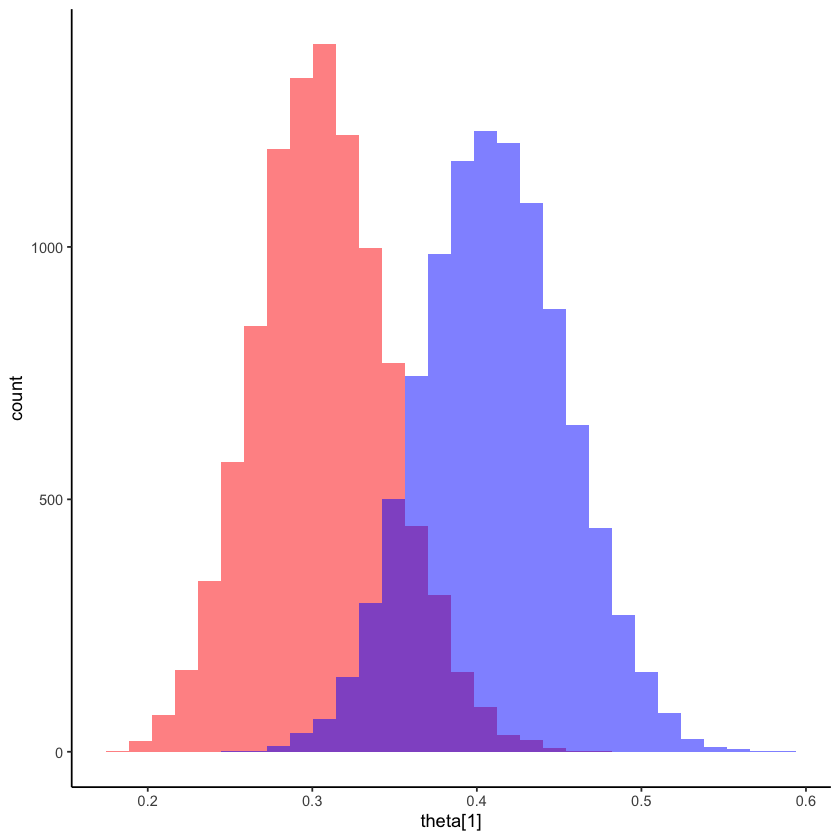

In [98]:
ggplot(results) + 
    geom_histogram(aes(x = `theta[1]`), fill = 'red', alpha = 0.5) + 
    geom_histogram(aes(x = `theta[2]`), fill = 'blue', alpha = 0.5) + theme_classic()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



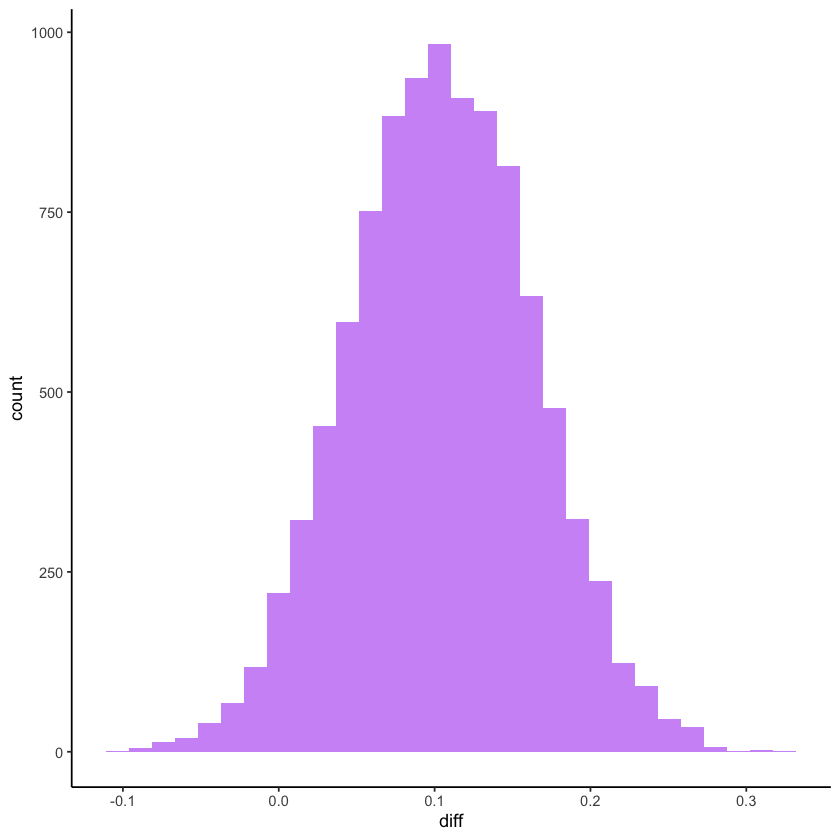

In [99]:
ggplot(results) + 
    geom_histogram(aes(x = diff), fill = 'purple', alpha = 0.5) + theme_classic()

In [102]:
# credible interval 
cat('Estimate of difference: ', mean(results$diff), '\n')
cat('95% credible interval for the difference:', quantile(results$diff, c(0.025, 0.975)))

Estimate of difference:  0.1047078 
95% credible interval for the difference: -0.009135713 0.2186282